In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 128
directory_root = './data'
width = 256
height = 256
depth = 3

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [3]:
image_paths = []
label_names = []

try:
    print("[INFO] Scanning image directories ...")
    # Get plant folders, ignoring .DS_Store
    root_dir = [d for d in os.listdir(directory_root) if d != ".DS_Store"]

    for plant_folder in root_dir:
        plant_path = os.path.join(directory_root, plant_folder)
        if not os.path.isdir(plant_path): continue

        # Get disease folders
        disease_folders = [d for d in os.listdir(plant_path) if d != ".DS_Store"]

        for disease_folder in disease_folders:
            disease_path = os.path.join(plant_path, disease_folder)
            if not os.path.isdir(disease_path): continue

            print(f"[INFO] Processing {disease_folder} ...")

            # Get images
            images = [f for f in os.listdir(disease_path) if f != ".DS_Store"]

            for image_file in images:
                file_path = os.path.join(disease_path, image_file)
                # Check extensions
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(file_path)
                    label_names.append(disease_folder)

    print(f"[INFO] Found {len(image_paths)} images.")

except Exception as e:
    print(f"Error : {e}")

[INFO] Scanning image directories ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Found 20638 images.


In [4]:
# Create Label Mappings
# Convert string labels (e.g., 'Tomato_Blight') to integers (0, 1, 2...)
unique_labels = sorted(list(set(label_names)))
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
n_classes = len(unique_labels)
print(f"[INFO] Classes: {unique_labels}")

# Convert all string labels to integers for the dataset
label_indices = [class_to_idx[name] for name in label_names]

[INFO] Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [5]:
# Split Data
# We split the paths, not the images. This is very fast and low memory.
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, label_indices, test_size=0.2, random_state=42, stratify=label_indices
)

In [6]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image ON DEMAND (Lazy Loading)
        image_path = self.image_paths[idx]

        # Open using PIL (Native RGB support, unlike OpenCV)
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a black image in case of error to prevent crash
            image = Image.new('RGB', (256, 256))

        if self.transforms:
            image = self.transforms(image)

        # Return label as a long tensor (required for CrossEntropyLoss)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
# Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(25),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create DataLoaders
train_dataset = PlantDataset(train_paths, train_labels, transforms=train_transforms)
test_dataset = PlantDataset(test_paths, test_labels, transforms=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=4)

In [8]:
# Model Definition
class PlantDiseaseCNN(nn.Module):
    def __init__(self, n_classes):
        super(PlantDiseaseCNN, self).__init__()

        # Dim calculations:
        # Input: 256 x 256 x 3

        # Block 1
        # Conv 32 (3x3, padding=1) -> 256 x 256
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # MaxPool (2x2) -> 256 / 2 = 128
        # Output: 32 x 128 x 128
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2
        # Conv 64 (3x3, padding=1) -> 128 x 128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3
        # Conv 64 (3x3, padding=1) -> 128 x 128
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # MaxPool (2x2) -> 128 / 2 = 64
        # Output: 64 x 64 x 64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Block 4
        # Conv 128 (3x3, padding=1) -> 64 x 64
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Block 5
        # Conv 128 (3x3, padding=1) -> 64 x 64
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        # MaxPool (2x2) -> 64 / 2 = 32
        # Output: 128 x 32 x 32
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Flatten -> Dense
        # Feature map size: 128 channels * 32 * 32 = 131,072
        self.fc1 = nn.Linear(128 * 32 * 32, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, n_classes)

    def forward(self, x):
        # Block 1: Conv -> BN -> ReLU -> Pool -> Dropout
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2 & 3: (Conv -> BN -> ReLU) x 2 -> Pool -> Dropout
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 4 & 5: (Conv -> BN -> ReLU) x 2 -> Pool -> Dropout
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Dense: FC -> BN -> ReLU -> Dropout -> FC
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [9]:
model = PlantDiseaseCNN(n_classes).to(device)

In [10]:
# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [11]:
print("[INFO] training network...")

# Lists to store history
history = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}

# Best model tracking
best_val_loss = float('inf')

# Training Loop
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_correct / val_total

    # Update scheduler
    scheduler.step(val_epoch_loss)

    # Save best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print(f"[INFO] Best model saved with val_loss: {val_epoch_loss:.4f}")

    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f} - "
          f"val_loss: {val_epoch_loss:.4f} - val_acc: {val_epoch_acc:.4f} - "
          f"time: {int(epoch_mins)}m {int(epoch_secs)}s")

[INFO] training network...
[INFO] Best model saved with val_loss: 0.5697
Epoch 1/25 - loss: 0.9725 - acc: 0.6825 - val_loss: 0.5697 - val_acc: 0.8055 - time: 0m 40s
[INFO] Best model saved with val_loss: 0.3856
Epoch 2/25 - loss: 0.5275 - acc: 0.8263 - val_loss: 0.3856 - val_acc: 0.8685 - time: 0m 38s
Epoch 3/25 - loss: 0.3921 - acc: 0.8698 - val_loss: 0.4753 - val_acc: 0.8421 - time: 0m 37s
[INFO] Best model saved with val_loss: 0.3114
Epoch 4/25 - loss: 0.3420 - acc: 0.8884 - val_loss: 0.3114 - val_acc: 0.8915 - time: 0m 38s
[INFO] Best model saved with val_loss: 0.2430
Epoch 5/25 - loss: 0.2773 - acc: 0.9092 - val_loss: 0.2430 - val_acc: 0.9113 - time: 0m 38s
[INFO] Best model saved with val_loss: 0.2305
Epoch 6/25 - loss: 0.2404 - acc: 0.9213 - val_loss: 0.2305 - val_acc: 0.9188 - time: 0m 38s
[INFO] Best model saved with val_loss: 0.1669
Epoch 7/25 - loss: 0.2173 - acc: 0.9269 - val_loss: 0.1669 - val_acc: 0.9455 - time: 0m 37s
Epoch 8/25 - loss: 0.1948 - acc: 0.9353 - val_loss: 0

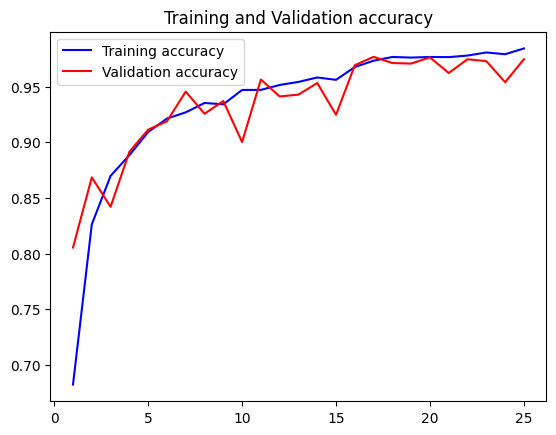

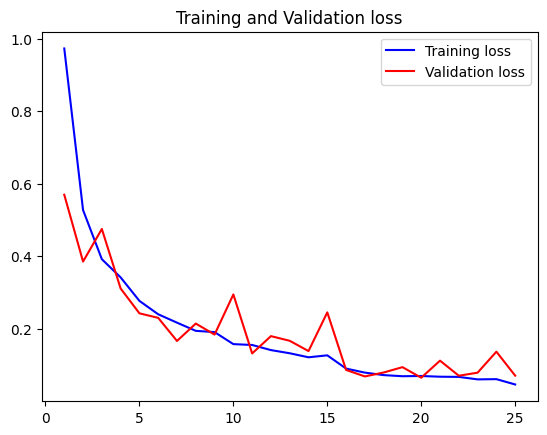

In [12]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs_range, acc, 'b', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.figure()
# Train and validation loss
plt.plot(epochs_range, loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [13]:
# Load best model for evaluation
print("[INFO] Loading best model for final evaluation...")
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(correct / total) * 100:.2f}")

[INFO] Loading best model for final evaluation...
Test Accuracy: 97.63
